In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

## Track analysis

This notebook is meant for the analysis of vessel tracks with the purpose of finding suspicious behaviour. Suspicious behaviour could be:
1. AIS gaps
2. Loitering near infrastructure
3. Slowing down near infrastructure
4. Route deviation
5. Sailing near critical infrastructure, such as naval bases
6. Ship to ship transfers, to a certain degree

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
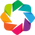

In [5]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

from math import sin, cos, atan2, radians, degrees, sqrt, pi
from pathlib import Path
import string
import random

import datashader as ds
import holoviews as hv
from shapely.geometry import LineString
from shapely import wkt
from holoviews.operation.datashader import spread
from holoviews.element import tiles
from holoviews import opts
import hvplot.pandas
import folium
from zipfile import ZipFile

hv.extension('bokeh', 'matplotlib')

R_EARTH = 6371000  # radius of earth in meters
C_EARTH = 2 * R_EARTH * pi  # circumference
BG_TILES = tiles.CartoLight()

In [3]:
# Set some constants

PATH = Path.cwd().parent.joinpath('data')

FIGSIZE = (600,400)
SMSIZE = 300
COLOR = 'darkblue'
COLOR_HIGHLIGHT = 'red'
COLOR_BASE = 'grey'

# Create a bounding box for North Sea

MIN_X = 0
MIN_Y = 50
MAX_X = 13
MAX_Y = 58

## 0. Prep data

Import, clean and do some EDA.

In [ ]:
## Let's create some useful functions (gracefully stolen from Anita Graser)

def time_difference(row: pd.Series
                    )-> pd.to_datetime:
    t1 = row['prev_t']
    t2 = row['time']

    return (t2-t1).total_seconds()

def speed_difference(row: pd.Series
                     )-> float:
    
    return row['speed_m/s'] - row['prev_speed']

def acceleration(row: pd.Series
                 )-> float:
    if row['diff_t_s'] == 0:
        return None
    
    return row['diff_speed'] / row['diff_t_s']

def spherical_distance(lon1: float, 
                       lat1: float, 
                       lon2: float, 
                       lat2: float
                       )-> float:
    
    delta_lat = radians(lat2 - lat1)
    delta_lon = radians(lon2 - lon1)
    a = sin(delta_lat/2) * sin(delta_lat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(delta_lon/2) * sin(delta_lon/2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    dist = R_EARTH * c
    
    return dist

def distance_to_prev(row: pd.Series
                     )-> float:
    
    return spherical_distance(row['prev_lon'], row['prev_lat'], row['longitude'], row['latitude'])
    
def distance_to_next(row: pd.Series
                     )-> float:
    
    return spherical_distance(row['next_lon'], row['next_lat'], row['longitude'], row['latitude'])

def direction(row: pd.Series
              )-> float:
    
    lon1, lat1, lon2, lat2 = row['prev_lon'], row['prev_lat'], row['longitude'], row['latitude']
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    delta_lon = radians(lon2 - lon1)
    x = sin(delta_lon) * cos(lat2)
    y = cos(lat1) * sin(lat2) - (sin(lat1) * cos(lat2) * cos(delta_lon))
    initial_bearing = atan2(x, y)
    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    
    return compass_bearing

def angular_difference(row: pd.Series
                       )-> float:
    
    diff = abs(row['prev_dir'] - row['dir'])
    if diff > 180:
        diff = abs(diff - 360)

    return diff 

def compute_segment_info(df: pd.DataFrame, 
                         identifier: str
                         )-> pd.DataFrame:
    
    df = df.copy()
    df['time'] = df.index
    df = df.sort_values('time')
    df['prev_t'] = df.groupby(identifier)['time'].shift()
    df['diff_t_s'] = df.apply(time_difference, axis=1)
    df['prev_lon'] = df.groupby(identifier)['longitude'].shift()
    df['prev_lat'] = df.groupby(identifier)['latitude'].shift()
    df['prev_x'] = df.groupby(identifier)['x'].shift()
    df['prev_y'] = df.groupby(identifier)['y'].shift()
    df['diff_x'] = df['x'] - df['prev_x']
    df['diff_y'] = df['y'] - df['prev_y']
    df['next_lon'] = df.groupby(identifier)['longitude'].shift(-1)
    df['next_lat'] = df.groupby(identifier)['latitude'].shift(-1)
    df['dist_prev_m'] = df.apply(distance_to_prev, axis=1)
    df['dist_next_m'] = df.apply(distance_to_next, axis=1)
    df['speed_m/s'] = df['dist_prev_m']/df['diff_t_s']
    df['prev_speed'] = df.groupby(identifier)['speed_m/s'].shift()
    df['diff_speed'] = df.apply(speed_difference, axis=1)
    df['acceleration'] = df.apply(acceleration, axis=1)
    df['dir'] = df.apply(direction, axis=1)
    df['prev_dir'] = df.groupby(identifier)['dir'].shift()
    df['diff_dir'] = df.apply(angular_difference, axis=1)
    df.drop(columns=['prev_x', 'prev_y', 'next_lon', 'next_lat', 'prev_speed', 'prev_dir', 'time'], axis=1, inplace=True)
    
    return df

def import_data(df: pd.DataFrame
                )-> pd.DataFrame:
    
    #df = pd.read_csv(file)
    #df.timestamp = pd.to_datetime(df.index)
    df.sort_values(by='timestamp', inplace=True)
    df['t'] = pd.to_datetime(df.timestamp)
    df.drop('timestamp', inplace=True, axis=1)
    df.set_index('t', drop=True, inplace=True)
    #df['name'] = file.stem
    #print(f'working on file: {file.stem}')

    # Set x and y in meters
    df = df.rename(columns={'lon': 'longitude', 'lat': 'latitude'})
    df.loc[:, 'x'], df.loc[:, 'y'] = ds.utils.lnglat_to_meters(df.longitude, df.latitude)

    df = compute_segment_info(df, 'vessel_name')

    return df

def create_gaps(df: pd.DataFrame, 
                identifier: str,
                gap_min: int, 
                gap_max: int
                )-> gpd.GeoDataFrame:

    df['is_gap'] = ( (df['dist_prev_m']>gap_min) & (df['dist_prev_m']<gap_max ) | ( (df['dist_next_m']>gap_min) & (df['dist_next_m']<gap_max) ) )
    df['id_by_gap'] = df.groupby(identifier)['is_gap'].transform(lambda x: x.ne(x.shift()).cumsum())
    df = df[(df.prev_lat.notna()) | (df.prev_lon.notna())].copy()

    df['geometry'] = df.apply(lambda row: LineString([(row.prev_lon, row.prev_lat), (row.longitude, row.latitude)]).wkt, axis=1)

    gdf = df.copy()

    gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
    gdf = gdf.set_geometry('geometry', crs=4326)

    return gdf

def plot_basic_scatter(df, color='darkblue', title='', width=FIGSIZE[0], height=FIGSIZE[1], size=2):
    opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
    pts = df.hvplot.scatter(x='x', y='y', datashade=True, cmap=[color, color], frame_width=width, frame_height=height, title=str(title))
    return BG_TILES * spread(pts, px=size)

def plot_point_density(df, title='', width=FIGSIZE[0], height=FIGSIZE[1]):
    opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
    pts = df.hvplot.scatter(x='x', y='y', title=str(title), datashade=True, frame_width=width, frame_height=height)
    return BG_TILES * pts


In [ ]:
# Import data

dfs = []
for vessel in PATH.joinpath('voi', 'gfw_tracks', 'raw').rglob('*.zip'):
    name = vessel.stem.split(' - ')[0]
    zf = ZipFile(vessel)
    df = pd.read_csv(zf.open('data.csv'))
    df['vessel_name'] = name.lower()
    dfs.append(df)

vessels = pd.concat(dfs)

len(vessels)


In [ ]:
# Write tracks to file
df=import_data(vessels)

In [ ]:
#df = pd.DataFrame(gdf.drop('geometry', axis=1))
df.to_parquet(PATH.joinpath('voi', 'processed', 'vessel_collection.parquet'))

### Perform some exploratory data analysis

We need to check for outliers, completeness and consistenc of the data.

In [ ]:
# Import data

gdf = gpd.read_parquet(PATH.joinpath('voi', 'processed', 'vessels_collection.parquet'))

In [ ]:
for name in gdf['name'].unique():
    gdf_ = gdf[gdf['name'] == name].copy()
    gdf_ = gdf_.cx[MIN_X:MIN_Y, MAX_X:MAX_Y]
    gdf_['speed_kmh'] = round((gdf_.dist_prev_m / 1000) / (gdf_.diff_t_s / 3600))
    gdf_ = gdf_[gdf_.speed_kmh < 20].copy()
    gdf_.to_file(PATH.joinpath('gis', 'vessels.gpkg'), layer=name, driver='GPKG')


In [ ]:
# Check spatial extent

print(f'Spatial extent:\nx_min={round(gdf.longitude.min(), 2)}, x_max={round(gdf.longitude.max(), 2)}\ny_min={round(gdf.latitude.min(), 2)}, y_max={round(gdf.latitude.max(), 2)}')

In [ ]:
# Check temporal extent

print(f'Temporal extent:\nmin_date={gdf.index.min()}\nmax_date={gdf.index.max()}')

In [ ]:
# Check distribution of records over time

TIME_SAMPLE = '15min'

gdf['name'].resample(TIME_SAMPLE).count()\
    .hvplot(title=f'Number of records per {TIME_SAMPLE}', width=FIGSIZE[0])

In [ ]:
# Check histogram of directions to spot coordinate imprecisions

gdf['dir'][gdf.dist_prev_m>0].hvplot.hist(bins=72, title='Histogram of directions')

In [ ]:
# Check histogram of speed (m/s)

gdf['speed_m/s'][gdf['speed_m/s']>0].hvplot.hist(bins=72, title='Histogram of speed')

In [ ]:
# Check histogram of time difference

gdf[gdf.diff_t_s < 20000].diff_t_s.hvplot.hist(bins=72, title='Histogram of time difference')

There is a very long tail of large time differences. This is probably caused by vessels being in the harbour for a long time (and AIS being turned off), being out of reach, or sailing without AIS. It's important to be mindful of these large temporal gaps, because they can also be an artefact of faulty equipment or poor reception and might be mistaken for deliberate AIS off switching.

## 1. Investigate gaps

Some vessels have gaps in their AIS signals that we could investigate. These events could be important because turning off AIS could be indicative of the crew trying to hide their whereabouts. For this we should:
1. Identify the points where a gap in AIS starts and end
2. The average speed between those points and how that speed relate to the speed prior and after the gap event.
3. Investigate the locations where these gaps are occuring
4. Check if the AIS gap could be intentional or is an artefact of the location (crowded or out of reach of base stations)
5. Find explanations for outliers

In [ ]:
# Take a subset

gdf = gpd.read_parquet(PATH.joinpath('vessels_collection.parquet'))
gaps = gdf[gdf.is_gap==True].copy()

ns_gdf = gaps.cx[MIN_X:MAX_X, MIN_Y:MAX_Y]
ns_gdf.reset_index()
len(ns_gdf)

In [ ]:

ns = ns_gdf[['geometry', 'name', 'speed_m/s']].copy()
ns.reset_index(drop=True, inplace=True)

m = ns[(ns.name=='ester') & (ns['speed_m/s'] < 10)].explore(cmap='fire', column='speed_m/s', name='Tracks', tiles='CartoDB Positron')
# this is completely optional
folium.LayerControl().add_to(m)

m

In [ ]:
vessel = ''

selection = ns_gdf[(ns_gdf['name']=='atlantic_lady') & (ns_gdf['speed_m/s'] < 5)].copy()
selection = selection[['speed_m/s', 'geometry']]
selection.reset_index(drop=True, inplace=True)
selection.explore(column='speed_m/s',
                  cmap='RdYlGn',
                  tiles='CartoDB Positron')

## 2. Loitering near infrastructure

We have all the loitering events for the vessels of interest. Let's import them and see where they are loitering (according to the algorithms of Global Fishing Watch). For caveats see [this documentation](https://globalfishingwatch.org/faqs/what-is-loitering-event/)

### Import data

In [4]:
# Create a geodataframe with all loitering events

gdfs = []

for file in PATH.joinpath('voi', 'gfw_data', 'events').glob('*events*.csv'):
    filename = file.stem.split('(')[0]
    df = pd.read_csv(file)
    if len(df) > 0:
        df['name'] = filename
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.longitude, y=df.latitude), crs=4326)
        gdfs.append(gdf)

events = pd.concat(gdfs)
events.to_file(PATH.joinpath('voi', 'processed', 'all_events.geojson'))

In [ ]:
# Or import directly

events = gpd.read_file(PATH.joinpath('voi', 'processed', 'all_events.geojson'))
len(events)


In [8]:
# Import pipelines and telecom

lines = gpd.read_parquet(PATH.joinpath('voi', 'context', 'gis', 'lines.parquet'))
lines.mps_uuid = lines.mps_uuid.apply(lambda x: ''.join(random.choices(string.ascii_lowercase + string.digits, k=16)) if x is None else x)
ns_lines = lines.cx[MIN_X:MAX_X, MIN_Y:MAX_Y].reset_index()
len(lines)

# Import platforms, connectors and seabed features

points = gpd.read_parquet(PATH.joinpath('voi', 'context', 'gis', 'points.parquet'))
points.mps_uuid = points.mps_uuid.apply(lambda x: ''.join(random.choices(string.ascii_lowercase + string.digits, k=16)) if x is None else x)
ns_points = points.cx[MIN_X:MAX_X, MIN_Y:MAX_Y].reset_index()
len(ns_points)

89679

### Perform spatial joins

In [21]:
# Filter out non-North Sea
gdfa = events.cx[MIN_X:MIN_Y, MAX_X:MAX_Y].copy()

gdfa = gdfa.to_crs(28992)
gdfb = ns_points.to_crs(28992)

df_n = gpd.sjoin_nearest(gdfa, gdfb).merge(gdfb, left_on="index_right", right_index=True)

# Calculate distance

df_n["distance"] = df_n.apply(lambda r: r["geometry_x"].distance(r["geometry_y"]) / 1000, axis=1)

# and clean it up

df_n.owner_x = df_n.owner_x.fillna(df_n.owner_y)

df_n.rename(columns={'type': 'event_type', 
                     'name_left': 'vessel_name', 
                     'mps_uuid_x': 'mps_uuid', 
                     'owner_x': 'owner', 
                     'owner_group_x': 'owner_group',
                     'operator_x': 'operator', 
                     'operator_group_x': 'operator_group',
                     'name': 'infra_name', 
                     'geometry_y': 'geometry_infra',
                     'geometry_x': 'geometry_event', 
                     'dataset_y': 'infrastructure_type'}, inplace=True)

df_n.columns = df_n.columns.str.lower()

df = df_n[['event_type', 'start', 'end', 'voyage', 'latitude', 'longitude', 'portvisitname', 'portvisitflag', 'vessel_name', 'geometry_event',
           'mps_uuid', 'infrastructure_type', 'owner', 'owner_group', 'operator', 'operator_group', 'infra_name', 'geometry_infra', 'distance']].copy()



In [24]:
# Find events within 5km (adapt distance to your liking)

distance = 5
df = df[df['distance'] < distance].copy()

gdf = gpd.GeoDataFrame(df, geometry=df.geometry_event, crs=28992)
gdf = gdf.drop(['geometry_infra', 'geometry_event'], axis=1)
gdf = gdf.to_crs(4326)

# Write to file
gdf.to_file(PATH.joinpath('voi', 'processed', 'events_near_infrastructure_points_5km.geojson'), driver='GeoJSON')